In [1]:
import pandas as pd
import numpy as np
import matplotlib
import xgboost as xgb

from sklearn import ensemble , cross_validation, learning_curve, metrics 
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%pylab inline

/Users/egor.iuganov/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/egor.iuganov/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


# Methodology

We are given a dataset with the Kickstarter projects data.
Our task is to understand the underlying factors predictive of project success. This suggests both data interpretability and model performance will be important: we will need to be able to explain which factors are associated with success and at the same time build a model that has an overall good predictive performance. Usually, simpler models are easier to interpret, while more powerful models can be more 'black box'. My strategy will therefore be to start with simpler models -- logistic regression and singleton decision tree -- to gain some basic intuition about the problem domain, before proceding to ensembling and boosting to generate a stronger success predictor.

In [2]:
# importing data
data = pd.read_csv('kick_starter.csv')
data.shape

(10000, 29)

In [3]:
data.head().iloc[:3,:]

,Unnamed: 0,id,photo,name,blurb,goal,state,slug,disable_communication,country,...,creator,location,category,profile,urls,source_url,friends,is_starred,is_backing,permissions
0,0,663816109,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Angular - Where Modern Art meets Cards,Angular is a minimalist card design for simpli...,17380.0,failed,angular-where-modern-art-meets-cards,False,US,...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN
1,1,1462931821,"{""small"":""https://ksr-ugc.imgix.net/assets/014...",Ladybeard is KAWAII-CORE,Original songs and music videos to jump start ...,24000.0,failed,ladybeard-is-kawaii-core,False,US,...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""JP"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN
2,2,1724358498,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Vegan Cafe Delivery Service in Vancouver BC,Our project is to launch a vegan lunch deliver...,40000.0,failed,vegancafeca,False,CA,...,"{""urls"":{""web"":{""user"":""https://www.kickstarte...","{""country"":""CA"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/discover/categorie...,NaN,NaN,NaN,NaN


In [4]:
# features
data.columns.values.tolist()

['Unnamed: 0',
 'id',
 'photo',
 'name',
 'blurb',
 'goal',
 'state',
 'slug',
 'disable_communication',
 'country',
 'currency',
 'currency_trailing_code',
 'deadline',
 'state_changed_at',
 'created_at',
 'launched_at',
 'staff_pick',
 'backers_count',
 'static_usd_rate',
 'creator',
 'location',
 'category',
 'profile',
 'urls',
 'source_url',
 'friends',
 'is_starred',
 'is_backing',
 'permissions']

In [5]:
data['category'][0]

'{"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/games/playing%20cards"}},"color":51627,"parent_id":12,"name":"Playing Cards","id":273,"position":4,"slug":"games/playing cards"}'

# Preprocessing

## Data cleaning

In [6]:
data['friends'].value_counts()

[]    11
Name: friends, dtype: int64

In [7]:
data['is_backing'].value_counts()

False    11
Name: is_backing, dtype: int64

In [8]:
data['is_starred'].value_counts()

False    11
Name: is_starred, dtype: int64

In [9]:
# looks like there is no valuable information in some features, so let's get rid of them
data = data.drop(['friends', 'is_starred', 'is_backing', 'permissions'], 1)
data.dropna().shape

(9650, 25)

In [10]:
# there are only 2 creators who contributed to more than 1 (2) projects, so let's omit this info for now
data['creator'].value_counts()

{"urls":{"web":{"user":"https://www.kickstarter.com/profile/2104052526"},"api":{"user":"https://api.kickstarter.com/v1/users/2104052526?signature=1500253731.d1f006fa03725838f5a48704bb741884dfa42cbb"}},"is_registered":true,"name":"Collectable Playing Cards","id":2104052526,"avatar":{"small":"https://ksr-ugc.imgix.net/assets/007/397/000/d3ec923d52b6133ea975e43128c1783a_original.jpg?w=160&h=160&fit=crop&v=1461454882&auto=format&q=92&s=68d5f12253f35f6a93f829267f7dcffd","thumb":"https://ksr-ugc.imgix.net/assets/007/397/000/d3ec923d52b6133ea975e43128c1783a_original.jpg?w=40&h=40&fit=crop&v=1461454882&auto=format&q=92&s=5de8ea80440046d2790a056baa4d3182","medium":"https://ksr-ugc.imgix.net/assets/007/397/000/d3ec923d52b6133ea975e43128c1783a_original.jpg?w=160&h=160&fit=crop&v=1461454882&auto=format&q=92&s=68d5f12253f35f6a93f829267f7dcffd"}}                         2
{"urls":{"web":{"user":"https://www.kickstarter.com/profile/gbsdetroit"},"api":{"user":"https://api.kickstarter.com/v1/users/9570

In [11]:
# the first column is not informative (index)
data = data.drop(data.columns[[0]], axis=1) 
data = data.drop(['creator','location', 'source_url', 'urls', 'profile', 'category', 'photo'], 1)# let's drop features with URLs...
data = data.drop(['name', 'blurb', 'slug'], 1) # ...and text (these can be analysyed later)

An issue with the 'backers_count' feature is discussed later

Missing data:

In [12]:
1 - data.dropna().shape[0] * 1.0 / data.shape[0]

0.029299999999999993

In [13]:
data[data.isnull().values.any(axis=1)].head()

,id,goal,state,disable_communication,country,currency,currency_trailing_code,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate
13,979551149,3500.0,successful,False,NaN,NaN,True,1472685671,1472685671,1469120486,1470093671,False,74,1.0
71,1423460390,1000.0,canceled,False,NaN,NaN,True,1458536400,1456851882,1456417429,1456444167,False,0,1.0
79,651614980,1200.0,failed,False,NaN,NaN,True,1387667369,1387667369,1382112949,1382479769,False,2,1.0
85,1898687880,20000.0,failed,False,NaN,NaN,True,1359959131,1359959131,1352585928,1357367131,False,50,1.0
157,89826059,1600.0,successful,False,NaN,NaN,True,1329868800,1329868823,1328584898,1328659871,False,33,1.0


There are a few missing values for countries and currencies in the dataset. The data is missing for less than 3% of the projects. We can completely remove them, but I will instead use one-hot encoding during the feature engineering stage and assign these projects to a broad 'other' group.

In [14]:
data[data['state'] == 'successful'].shape[0]*1.0 / data.shape[0]

0.4549

It is important to determine appropriate performance metrics for the predictive models early on: for instance, in unbalanced datasets accuracy may not be a good metric. However, our classes are roughly balanced: 45% of projects in the data are labelled as successful. This suggests we may be justified in evaluating our models based on accuracy.

In [15]:
data.drop_duplicates().shape

(10000, 14)

Cheched for dublicates

## Feature engineering

### Country encoding

Let's have a look at the currency and country distributions:

In [16]:
data['currency'].value_counts()

USD    7794
GBP     791
EUR     392
CAD     374
AUD     181
NZD      45
SEK      40
MXN      26
NOK      25
CHF      15
DKK      15
HKD       5
SGD       4
Name: currency, dtype: int64

In [17]:
data['country'].value_counts()

US    7794
GB     791
CA     374
AU     181
DE      98
IT      74
NL      72
FR      59
ES      46
NZ      45
SE      40
MX      26
NO      25
IE      20
CH      15
BE      15
DK      15
AT       8
HK       5
SG       4
Name: country, dtype: int64

There are 20 possible values for countries. If we apply one-hot encoding, we would have a lot of variables, many of which are sparse: the vast majority of projects are from a small list of countries. Hence, for the country variable, I only create variables for countries with more than 100 projects and the remaining are encoded as 'other' (including NAs).

In [18]:
country_frequencies = data.groupby('country', as_index = False).size().reset_index()
country_frequencies.columns = ['country', 'frequency']
countries_over_100 = [x['country'] for _, x in country_frequencies.iterrows() if x['frequency'] >= 100]

def encode_countries(row):
    
    global countries_over_100
    
    indicators_list = []
    for country in countries_over_100:
        indicator = 1 if row[0] == country else 0
        indicators_list.append(indicator)
    
    indicator_other = 1 if (1 not in indicators_list) else 0
    indicators_list.append(indicator_other)
    
    return pd.Series(indicators_list, index = ['country_' + x for x in countries_over_100] + ['country_other'])

country_encoding = data[['country']].apply(encode_countries, axis=1)
data = pd.concat([data, country_encoding], axis=1)

In [19]:
data.head()

,id,goal,state,disable_communication,country,currency,currency_trailing_code,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,country_AU,country_CA,country_GB,country_US,country_other
0,663816109,17380.0,failed,False,US,USD,True,1459283229,1459283230,1455845363,1456694829,False,11,1.000000,0,0,0,1,0
1,1462931821,24000.0,failed,False,US,USD,True,1484110800,1484110800,1475568868,1480946454,False,304,1.000000,0,0,0,1,0
2,1724358498,40000.0,failed,False,CA,CAD,True,1408549628,1408549628,1405218883,1405957628,False,2,0.926746,0,1,0,0,0
3,314918941,1000.0,successful,False,US,USD,True,1364084914,1364084914,1360627778,1361496514,False,18,1.000000,0,0,0,1,0
4,1766165140,700.0,failed,False,GB,GBP,False,1382600001,1382600002,1379704502,1380008001,False,0,1.602384,0,0,1,0,0


We could use the same method for the currencies, but 
- it would increase the number of features significantly
- the currency features would be almost identical to the country features, hence we wouldn't get any new information

### Convering 'goal' into USD

In order to be able to compare the 'goal' variable for different projects, I convert this feature into USD for all projects

In [20]:
goal_usd = data['goal'].multiply(data['static_usd_rate'])

In [21]:
data = pd.concat([data, goal_usd.rename('goal_usd')], axis=1)

In [22]:
data.head()

,id,goal,state,disable_communication,country,currency,currency_trailing_code,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,country_AU,country_CA,country_GB,country_US,country_other,goal_usd
0,663816109,17380.0,failed,False,US,USD,True,1459283229,1459283230,1455845363,1456694829,False,11,1.000000,0,0,0,1,0,17380.000000
1,1462931821,24000.0,failed,False,US,USD,True,1484110800,1484110800,1475568868,1480946454,False,304,1.000000,0,0,0,1,0,24000.000000
2,1724358498,40000.0,failed,False,CA,CAD,True,1408549628,1408549628,1405218883,1405957628,False,2,0.926746,0,1,0,0,0,37069.850800
3,314918941,1000.0,successful,False,US,USD,True,1364084914,1364084914,1360627778,1361496514,False,18,1.000000,0,0,0,1,0,1000.000000
4,1766165140,700.0,failed,False,GB,GBP,False,1382600001,1382600002,1379704502,1380008001,False,0,1.602384,0,0,1,0,0,1121.669045


### Date and time features

The date and time data contains a lot of information that is likely to be predictive of project success, however several transformations are required. Since we are interested in the projects with a known a known outcome (the deadline has passed), 'deadline' and 'state_changed_at' variables are the same. An interesting group of variables may be obtained from the 'deadline' and 'created_at' variables:
- fund raising time lapse;
- creation time relative to the earliest project;

The Unix epoch is the number of seconds that have elapsed since January 1, 1970, not counting leap seconds. To get the number of days between launch and deadline we can just find the number of seconds between these two dates and convert it into days

In [23]:
# fund raising time lapse in days
fr_time_days = (data['deadline'] - data['launched_at']) * 1.0 / 86400
data = pd.concat([data, fr_time_days.rename('fr_time_days')], axis=1)

In [24]:
# creation time in days relative to the earliest project
rel_cr_time_days = (data['created_at'] - min(data['created_at'])) / 86400
data = pd.concat([data, rel_cr_time_days.rename('rel_cr_time_days')], axis=1)

In [25]:
data.head()

,id,goal,state,disable_communication,country,currency,currency_trailing_code,deadline,state_changed_at,created_at,...,backers_count,static_usd_rate,country_AU,country_CA,country_GB,country_US,country_other,goal_usd,fr_time_days,rel_cr_time_days
0,663816109,17380.0,failed,False,US,USD,True,1459283229,1459283230,1455845363,...,11,1.000000,0,0,0,1,0,17380.000000,29.958333,2494.329028
1,1462931821,24000.0,failed,False,US,USD,True,1484110800,1484110800,1475568868,...,304,1.000000,0,0,0,1,0,24000.000000,36.624375,2722.610336
2,1724358498,40000.0,failed,False,CA,CAD,True,1408549628,1408549628,1405218883,...,2,0.926746,0,1,0,0,0,37069.850800,30.000000,1908.374398
3,314918941,1000.0,successful,False,US,USD,True,1364084914,1364084914,1360627778,...,18,1.000000,0,0,0,1,0,1000.000000,29.958333,1392.273646
4,1766165140,700.0,failed,False,GB,GBP,False,1382600001,1382600002,1379704502,...,0,1.602384,0,0,1,0,0,1121.669045,30.000000,1613.069062


### Converting date and time into conventional format

Although date and time in conventional format will not be used, it is useful to check that the transformation above is correct

In [26]:
import datetime    

col_date=['state_changed_at','created_at','launched_at','deadline']

for i in col_date:
    data[i]=data[i].apply(lambda x: 
    datetime.datetime.fromtimestamp(int(x)).strftime("%Y-%m-%d %H:%M:%S"))

In [27]:
data.head().iloc[:3,:]

,id,goal,state,disable_communication,country,currency,currency_trailing_code,deadline,state_changed_at,created_at,...,backers_count,static_usd_rate,country_AU,country_CA,country_GB,country_US,country_other,goal_usd,fr_time_days,rel_cr_time_days
0,663816109,17380.0,failed,False,US,USD,True,2016-03-29 21:27:09,2016-03-29 21:27:10,2016-02-19 01:29:23,...,11,1.000000,0,0,0,1,0,17380.0000,29.958333,2494.329028
1,1462931821,24000.0,failed,False,US,USD,True,2017-01-11 05:00:00,2017-01-11 05:00:00,2016-10-04 09:14:28,...,304,1.000000,0,0,0,1,0,24000.0000,36.624375,2722.610336
2,1724358498,40000.0,failed,False,CA,CAD,True,2014-08-20 16:47:08,2014-08-20 16:47:08,2014-07-13 03:34:43,...,2,0.926746,0,1,0,0,0,37069.8508,30.000000,1908.374398


Now let's drop the features we no longer use

In [28]:
data.drop(labels=['goal', 'country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'static_usd_rate'], axis=1, inplace=True)

In [29]:
data.head()

,id,state,disable_communication,currency_trailing_code,staff_pick,backers_count,country_AU,country_CA,country_GB,country_US,country_other,goal_usd,fr_time_days,rel_cr_time_days
0,663816109,failed,False,True,False,11,0,0,0,1,0,17380.000000,29.958333,2494.329028
1,1462931821,failed,False,True,False,304,0,0,0,1,0,24000.000000,36.624375,2722.610336
2,1724358498,failed,False,True,False,2,0,1,0,0,0,37069.850800,30.000000,1908.374398
3,314918941,successful,False,True,False,18,0,0,0,1,0,1000.000000,29.958333,1392.273646
4,1766165140,failed,False,False,False,0,0,0,1,0,0,1121.669045,30.000000,1613.069062


### Transforming 'state' variable

In [30]:
data['state'].value_counts()

failed        4631
successful    4549
canceled       601
live           179
suspended       40
Name: state, dtype: int64

Over 91% of the projects have either 'failed' or 'successful' states. Here I assume that we are interested whether a project would be successful or not, hence the information about live, suspended and canceled projects cannot help us too much, so I do not use it.

In [31]:
data = data[data['state'] != 'live']
data = data[data['state'] != 'suspended']
data = data[data['state'] != 'canceled']

In [32]:
data['state'].value_counts()

failed        4631
successful    4549
Name: state, dtype: int64

In [33]:
data['state'].replace('failed', 0, inplace=True)
data['state'].replace('successful', 1, inplace=True)

In [34]:
data.head()

,id,state,disable_communication,currency_trailing_code,staff_pick,backers_count,country_AU,country_CA,country_GB,country_US,country_other,goal_usd,fr_time_days,rel_cr_time_days
0,663816109,0,False,True,False,11,0,0,0,1,0,17380.000000,29.958333,2494.329028
1,1462931821,0,False,True,False,304,0,0,0,1,0,24000.000000,36.624375,2722.610336
2,1724358498,0,False,True,False,2,0,1,0,0,0,37069.850800,30.000000,1908.374398
3,314918941,1,False,True,False,18,0,0,0,1,0,1000.000000,29.958333,1392.273646
4,1766165140,0,False,False,False,0,0,0,1,0,0,1121.669045,30.000000,1613.069062


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9180 entries, 0 to 9999
Data columns (total 14 columns):
id                        9180 non-null int64
state                     9180 non-null int64
disable_communication     9180 non-null bool
currency_trailing_code    9180 non-null bool
staff_pick                9180 non-null bool
backers_count             9180 non-null int64
country_AU                9180 non-null int64
country_CA                9180 non-null int64
country_GB                9180 non-null int64
country_US                9180 non-null int64
country_other             9180 non-null int64
goal_usd                  9180 non-null float64
fr_time_days              9180 non-null float64
rel_cr_time_days          9180 non-null float64
dtypes: bool(3), float64(3), int64(8)
memory usage: 887.5 KB


In [36]:
data.dropna().shape[0] * 1.0 / data.shape[0]

1.0

There are no more missing values

# Exploratory Data Analysis

I start with learning how the number of project changes whith some of the variables: fund raising time, goal and number of backers. As we can see below, several observations can be made:
- the majority of the projects were raising funds for approximately 1 month; in general projects with less fund raising time were more likely to succeed
- the projects with goals under 5000USD were more successful
- successful projects had many backers (this was expected)

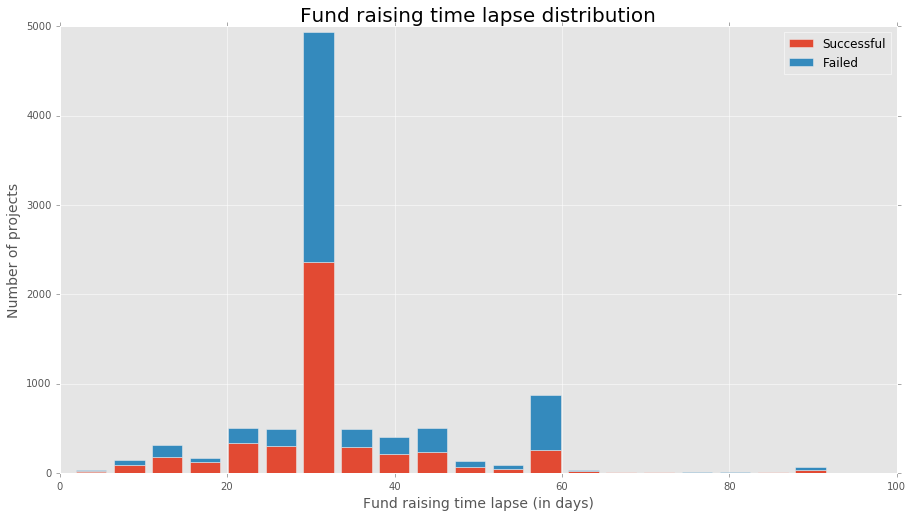

In [37]:
plt.figure(figsize=(15,8))
plt.hist([data[data['state']==1]['fr_time_days'],
          data[data['state']==0]['fr_time_days']], 
         stacked=True, bins = 20,label = ['Successful','Failed'])
plt.xlabel('Fund raising time lapse (in days)', fontsize=14)
plt.ylabel('Number of projects', fontsize=14)
plt.legend()
plt.title('Fund raising time lapse distribution', fontsize=20)
#plt.savefig('by_age.png', format='png', dpi=600, transparent=True)
plt.show()

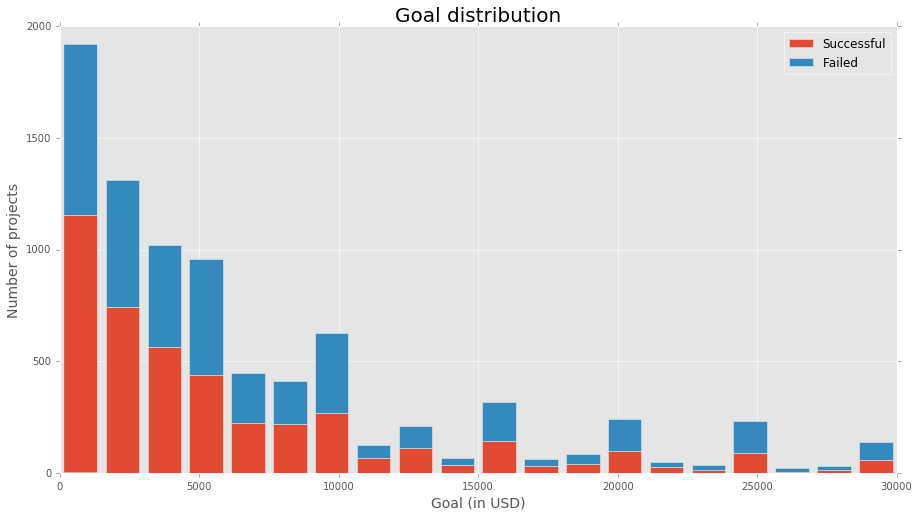

In [38]:
plt.figure(figsize=(15,8))
plt.hist([data[data['state']==1]['goal_usd'],
          data[data['state']==0]['goal_usd']], 
         stacked=True, bins = 20,label = ['Successful','Failed'],range = (0, 3*10**4))
#plt.yscale('log', nonposy='clip')
plt.xlabel('Goal (in USD)', fontsize=14)
plt.ylabel('Number of projects', fontsize=14)
plt.legend()
plt.title('Goal distribution', fontsize=20)
#plt.savefig('by_age.png', format='png', dpi=600, transparent=True)
plt.show()

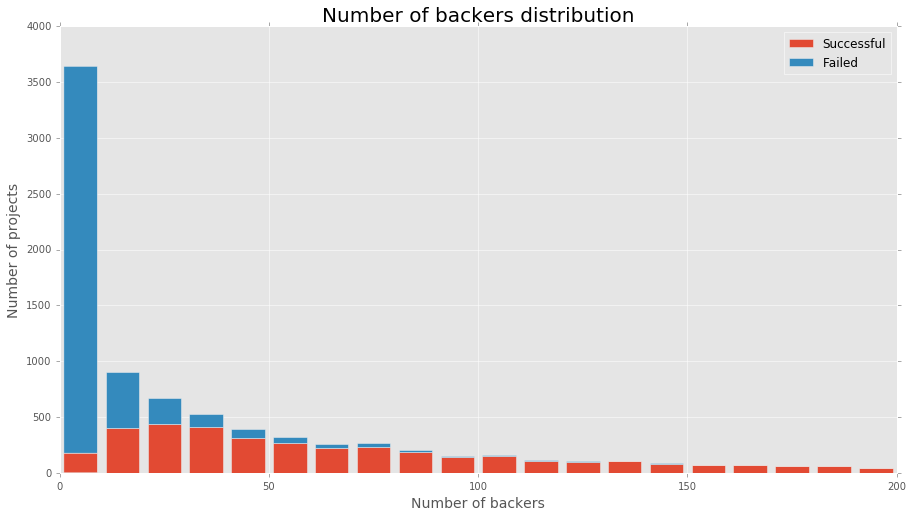

In [39]:
plt.figure(figsize=(15,8))
plt.hist([data[data['state']==1]['backers_count'],
          data[data['state']==0]['backers_count']], 
         stacked=True, bins = 20,label = ['Successful','Failed'],range = (0, 2*10**2))
#plt.yscale('log', nonposy='clip')
plt.xlabel('Number of backers', fontsize=14)
plt.ylabel('Number of projects', fontsize=14)
plt.legend()
plt.title('Number of backers distribution', fontsize=20)
#plt.savefig('by_age.png', format='png', dpi=600, transparent=True)
plt.show()

Now let's have a look at the countries where the projects were developed. It can be seen that in this sample projects from Australia fail more often compared to the other countries, whereas projects from Canada and the 'other' countries tend to succeed. It is worth mentioning that this sample is not perfectly balanced and not very big, so these results should be interpreted with caution

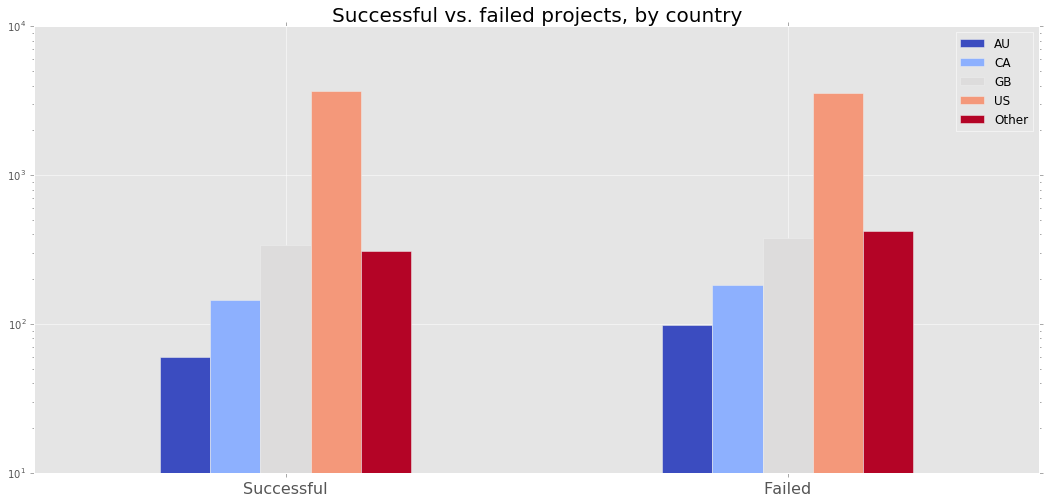

In [40]:
country_indicators = ['country_AU', 'country_CA', 
                      'country_GB', 'country_US', 'country_other']

failed = data[data['state']==1][country_indicators].sum()
successful = data[data['state']==0][country_indicators].sum()
df = pd.DataFrame([failed, successful])
df.index = ['Successful','Failed']
df.plot(kind='bar', stacked=False, figsize=(18,8), colormap='coolwarm', logy=True)

plt.legend(loc='best', labels=['AU', 'CA', 'GB', 
                               'US', 'Other'],
          frameon=True)
plt.xticks(size=16,rotation=0)
plt.title('Successful vs. failed projects, by country', fontsize=20)
plt.show()

# Prediction modeling

In [71]:
#import statsmodels.api as sm

from sklearn.preprocessing import MaxAbsScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.svm import LinearSVC

/Users/egor.iuganov/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [72]:
X = data.drop('state', 1)
y = data['state']

Before building our machine learning models, we need to perform the train-test split and put aside the test set until performance evaluation stages. By evaluating our models on previously unseen data, we will obtain an unbiased estimate of the model's out-of-sample performance. For model selection, we will generally use cross-validation (which may be slower on a relatively large dataset like ours than simply using an extra validation set, but is efficiently implemented in various libraries).

In [73]:
features_train, features_test, state_train, state_test = train_test_split(X, y, test_size = 0.2)

In [74]:
features_train.shape

(7344, 13)

In [75]:
features_test.shape

(1836, 13)

### Rescaling the data

Our features have varying scales -- while many are binary indicators, several (esp. those measuring purchasing activity) are on a much wider scale. This will generally slow down the performance of learning algorithms and may complicate the comparison of factor coefficients.

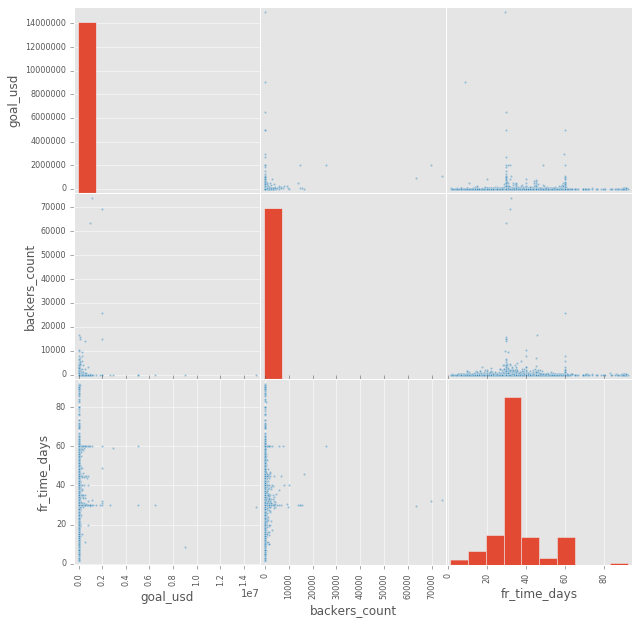

In [76]:
from pandas.tools.plotting import scatter_matrix

list_cols = ['goal_usd', 'backers_count', 'fr_time_days']
scatter_matrix(data[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

It can be seen that the features have different orders of magnitude

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.fit_transform(features_test)

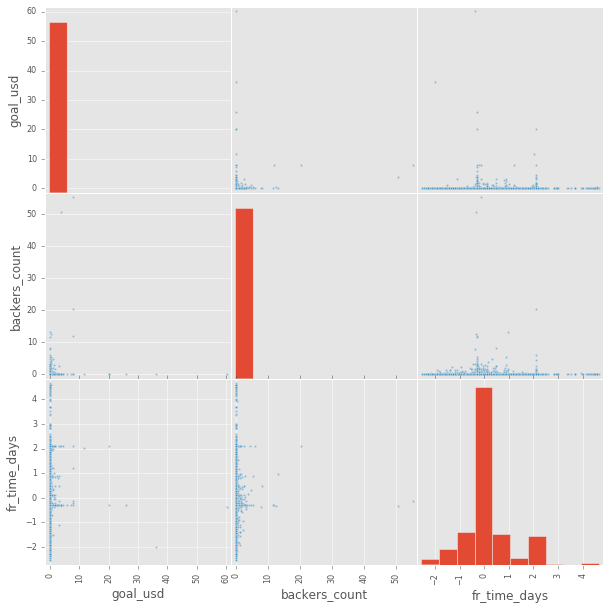

In [78]:
features_train_scaled = pd.DataFrame(features_train, columns=list(X))
features_test_scaled = pd.DataFrame(features_test, columns=list(X))
list_cols = ['goal_usd', 'backers_count', 'fr_time_days']
scatter_matrix(features_train_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

## Logistic Regression

Logistic regression is one of the simplest, but useful models that we can fit for our task. It is a linear classifier and will attempt to find a linear decision boundary separating the two classes in our data (active and churned). It is unlikely that the true relationship between state and other customer variables is linear, hence we would not expect the model to have excellent predictive performance as it suffers from high bias.<br><br>
However, it is a useful benchmark for more sophisticated models and can be quickly computed. In addition, logistic regression outputs coefficients for every variable, which would help us make sense of the factors that are positively or negatively associated with success. Finally, another advantage of using logistic regression is that it outputs probabilities of classes which can be useful to assess the model's confidence in its predictions. In addition, we can vary the threshold for state classification and thus trade off true positive and false positive rates, depending on what is more beneficial for our domain.<br><br>
Other issues we face in using logistic regression is its vulnerability to multicollinearity issue and possibly overfitting. The former is particularly a concern, because we have sets of indicators (e.g., premier dummies) that would be linearly dependent with a constant term and the learning algorithm will fail to converge. To combat overfitting, we will also need to apply regularization (which introduces bias into coefficients, but reduces model variance and hopefully will improve predictive accuracy).

In [79]:
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
#param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10**4, 10**5]}
cv = 3

In [80]:
estimator = LogisticRegression('l2')
optimizer = GridSearchCV(estimator, param_grid, cv=3)

In [81]:
#features_test_scaled = features_test_scaled.drop(['backers_count'], 1)
#features_train_scaled = features_train_scaled.drop(['backers_count'], 1)

In [82]:
optimizer.fit(features_train_scaled, state_train)
predictions_zeros = optimizer.predict(features_test_scaled)
auc_1 = roc_auc_score(state_test, optimizer.predict_proba(features_test_scaled)[:,1])
print('Best auc score: {}'.format(auc_1))
print('Best accuracy cross validation score: {}'.format(optimizer.best_score_))
print('Best parameters: {}'.format(optimizer.best_params_))

Best auc score: 0.873881442718
Best accuracy cross validation score: 0.915849673203
Best parameters: {'C': 10000}


In [83]:
#plot_scores(optimizer)

In [84]:
best_logistic_model = optimizer.best_estimator_

coef_table = pd.DataFrame({'_feature': features_train_scaled.columns, 
                   'coefficient': best_logistic_model.coef_[0]})
coef_table.sort_values(by='coefficient', ascending=False)

,_feature,coefficient
4,backers_count,84.878314
2,currency_trailing_code,0.260301
7,country_GB,0.143271
3,staff_pick,0.075529
9,country_other,0.026916
1,disable_communication,0.000000
6,country_CA,-0.029103
5,country_AU,-0.030759
0,id,-0.038115
8,country_US,-0.088685


The 'backers_count' feature is much more important than the others. We will discuss this later.

To summarise this logistic regression model, it achieves 64.2% accuracy, calculated using cross-validation. The optimal regularization parameter C is 1000.

## Performance Evaluation

I now turn to evaluating the model on the test set. A simple accuracy metric as above may be insufficient for our problem. In particular, we may be much more concerned with false negative (projects which succeeded, but were predicted not to) than false positive (customers who did not succeed, but were predicted to). <br><br>
To address this, visualising a confusion matrix and plotting an ROC curve can be useful. From the confusion matrix, we can calculate recall (or sensitivity) -- the ability of our model to correctly identify churned customers. Moreover, the ROC curve visualises how we can trade off true positive rate and false positive rates, by varying classification thresholds, something the accuracy metric, for instance, cannot achieve.<br><br>
In addition, the area-under-the-curve (AUC) that we can calcuate from the ROC curve also quantifies the probability that a random positive case (i.e., successful project) will be assigned a higher probability than a random negative case (i.e., failed project). The AUC score will provide us with a measure of classification performance that is not dependent on particular thresholds we may choose. It would also be a more reliable assessment of our model if the classes in the population are not as balanced as in our data.

In [85]:
success_prediction = best_logistic_model.predict(features_test_scaled)

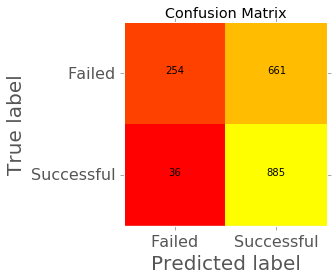

In [86]:
def plot_confusion_matrix(cnf_matrix, class_labels, title='Confusion Matrix', cmap='autumn'):
    import itertools
        
    fig, ax = plt.subplots(nrows=1)
    ax.imshow(cnf_matrix, interpolation='none', cmap=cmap)
    #plt.axis('off')
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    
    ax.set_xticklabels(class_labels, fontsize=16)
    ax.set_yticklabels(class_labels, fontsize=16)
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.annotate(str(cnf_matrix[i, j]), xy=(j, i), horizontalalignment='center')
        
    ax.set_ylabel('True label', fontsize=20)
    ax.set_xlabel('Predicted label', fontsize=20)
    ax.set_title(title)
    ax.grid(False)
    
cnf_matrix = confusion_matrix(state_test, success_prediction)

plot_confusion_matrix(cnf_matrix, ['Failed', 'Successful'])
#plt.savefig('confusion_matrix.png', format='png', dpi=600, transparent=True)
plt.tight_layout()

In [87]:
print(classification_report(state_test, success_prediction, target_names=['Failed', 'Successful']))

             precision    recall  f1-score   support

     Failed       0.88      0.28      0.42       915
 Successful       0.57      0.96      0.72       921

avg / total       0.72      0.62      0.57      1836



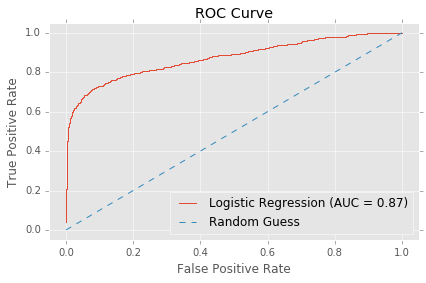

In [88]:
# ROC curve and AUC score

def plot_roc_curve(y_test, y_pred_proba):
    classifier_label='Logistic Regression'
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
    roc_auc = auc(fpr, tpr)
    
    figure, ax = plt.subplots(1,1)
    
    #if 1:
    
    ax.plot(fpr, tpr, lw=1, label = classifier_label + ' (AUC = %.2f)' %(roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', fc='darkorange', alpha=0.5)
    
    '''for thres in [0.3, 0.5, 0.6]:
        idx = np.where(np.round(thresholds, 2) == thres)[0][0]
        threshold = np.round(thresholds[idx], 2)
        ax.annotate('Threshold = ' + str(thres), xy=(fpr[idx], tpr[idx]),
                xytext=(fpr[idx]-0.12, tpr[idx]+0.06),
                arrowprops=dict(facecolor='gray', shrink=5, headwidth=2), horizontalalignment='left',
                    fontsize=8
                   )'''
               
    
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.set_title('ROC Curve')
    plt.legend(frameon=True, loc='lower right')
    

state_predicted_probs = best_logistic_model.predict_proba(features_test_scaled)
 
plot_roc_curve(state_test, state_predicted_probs[:, 1])
plt.tight_layout()

# Decision trees

Decision trees are a class of much more flexible models than logistic regression, as they are not constrained to only find linear decision boundaries. However, that makes them much more prone to overfitting as they fit the noise in the training set too much and may fail to generalise to test sets. In the bias-variance trade-off language, decision trees have lower bias, but (potentially much) higher variance than a linear classifier such as logistic regression.<br><br>
I start with a single tree (with some parameter tuning), because then we can visualise it.

In [89]:
#features_train_unscaled = X
#features_train_unscaled = pd.DataFrame(data=max_features_train.inverse_transform(features_train), 
#                                       columns=feature_df.columns)
decision_tree = DecisionTreeClassifier(max_features='sqrt', criterion='entropy')

parameter_grid_tree = {'max_depth': [3, 4, 5],
                       'max_leaf_nodes': [4, 6, 8]
                      }

grid_search_tree = GridSearchCV(decision_tree, 
                                param_grid=parameter_grid_tree,
                               cv=5)

#grid_search_tree.fit(features_train_unscaled, state_train)
grid_search_tree.fit(features_train_scaled, state_train)

print('Best score: {}'.format(grid_search_tree.best_score_))
print('Best parameters: {}'.format(grid_search_tree.best_params_))

best_tree = grid_search_tree.best_estimator_

Best score: 0.805691721133
Best parameters: {'max_leaf_nodes': 8, 'max_depth': 5}


This decision tree model achieves an accuracy score of 0.628 which is worse compared to logistic regression.

### Visualizing a decision tree

/Users/egor.iuganov/anaconda/lib/python2.7/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


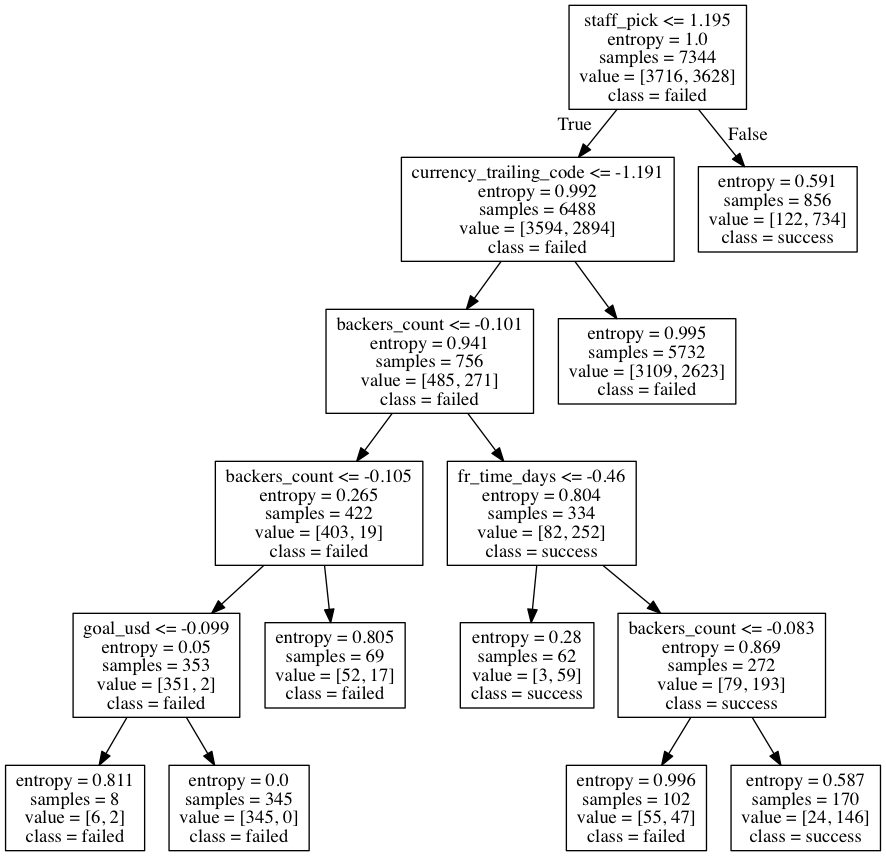

In [90]:
from IPython.display import Image
from os import system

export_graphviz(best_tree, feature_names = list(features_train_scaled), class_names=['failed', 'success'])
system("dot -Tpng tree.dot -o dtree.png")
Image(filename='dtree.png')

# Boosting and ensembling

A powerful way of addressing weaknesses of decision trees are boosting and ensembling. Boosting involves a sequential learning process, where we make each new tree learn on the mistakes of the previous one by weighting those observations higher. On the other hand, ensembling refers to combining multiple weak learners into a single, much stronger classifier -- this essentially reduces model variance, because weak learners do not fit the noise as much.<br><br>
While there are several choices for algorithms that build up on decision trees, I implement a gradient boosting machine, which has proven to perform very well in classification contexts. A gradient boosting classifier performs gradient descent in the space of functions and hence can learn a good approximation to the true relationship without requiring us to make strong modelling assumptions.<br><br>
Among the disadvantages, however, are computational intensity involved in tuning parameters and the black box nature of the algorithm, at least relative to logistic regression (for example, it does not provide us with individual variable coefficients).

In [91]:
%%time
#n_trees = [1] + range(10, 55, 5) 
n_trees = [1] + range(10, 100, 5) 

# let's use xgboost as our model and find the score using cross-validation with 3 folds
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = cross_validation.cross_val_score(estimator, features_test_scaled, state_test, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: user 3.19 s, sys: 26.4 ms, total: 3.22 s
Wall time: 3.34 s


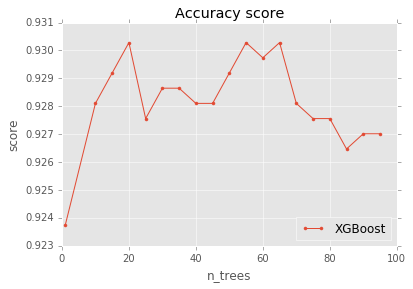

In [92]:
# let's have a look how accuracy changes with the number of trees
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

In [93]:
# let's also find the score for 100 trees
estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, min_child_weight=3)
score = cross_validation.cross_val_score(estimator, features_test_scaled, state_test, 
                                        scoring = 'accuracy', cv = 3) 
score.mean()

0.92647058823529405

In [94]:
estimator.fit(features_test_scaled, state_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [95]:
feature_importances = pd.DataFrame(estimator.feature_importances_).T
feature_importances.columns = list(features_train_scaled)

In [96]:
feature_importances

,id,disable_communication,currency_trailing_code,staff_pick,backers_count,country_AU,country_CA,country_GB,country_US,country_other,goal_usd,fr_time_days,rel_cr_time_days
0,0.105035,0.0,0.000868,0.011285,0.306424,0.0,0.0,0.006076,0.008681,0.001736,0.280382,0.105035,0.174479


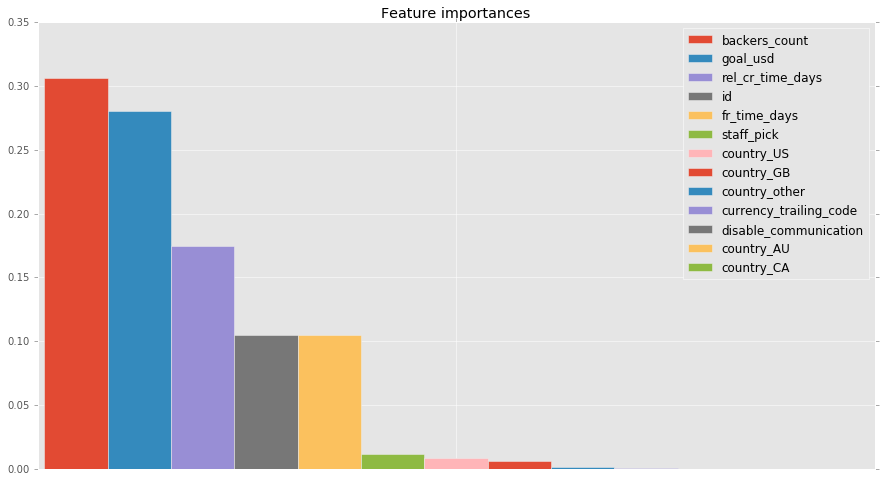

In [97]:
feature_importances = feature_importances.T.sort_values(by=0, ascending=False).T

feature_importances.plot(kind='bar', width=30, figsize=(15,8))
plt.tick_params(axis='x', bottom='off', labelbottom='off')
plt.title('Feature importances')
# plt.grid(b=False)
plt.legend(frameon=True)
plt.show()

Although the 'backers_count' is still the most important feature, the distribution of the others is quite different.

In [98]:
state_predicted_probs_xgb = estimator.predict_proba(features_test_scaled)
state_prediction_xgb = estimator.predict(features_test_scaled)

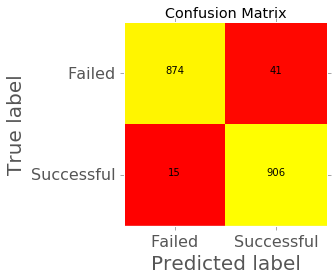

In [99]:
cnf_matrix_gbm = confusion_matrix(state_test, state_prediction_xgb)

plot_confusion_matrix(cnf_matrix_gbm, ['Failed', 'Successful'])
#plt.savefig('cnf_gbm.png', format='png', dpi=600, transparent=True)
plt.tight_layout()

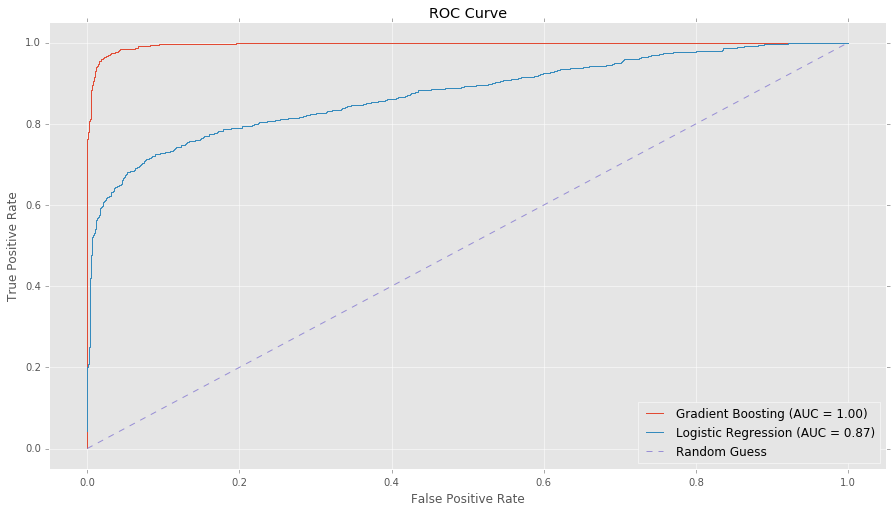

In [100]:
predictions = {'Logistic Regression': state_predicted_probs,
              'Gradient Boosting': state_predicted_probs_xgb}

plt.figure(figsize=(15,8))
for model, preds in predictions.items():
    fpr, tpr, thresholds = roc_curve(state_test, preds[:, 1]) 
    roc_auc = auc(fpr, tpr)
        
    plt.plot(fpr, tpr, lw=1, label = model + ' (AUC = %.2f)' %(roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC Curve')
plt.legend(frameon=True, loc='lower right')
plt.show()

The gradient boosting classifier outperforms logistic regression -- its higher AUC score suggests it is better at identifying churned customers. By looking at the confusion matrix above, we can also observe that this is achieved by a reduction in both false positive and false negative.

# Issue with the number of backers

The scores above look too good: the reason is the 'most important' feature, number of backers. It becomes available only after a fundraising is finished, hence we cannot use it to predict success of a project before deadline. Here I repeat the calculations assuming this feature is not available.

In [101]:
# deleting the 'backers_count' feature
features_test_scaled = features_test_scaled.drop(['backers_count'], 1)
features_train_scaled = features_train_scaled.drop(['backers_count'], 1)

In [102]:
# Logistic Regression
optimizer.fit(features_train_scaled, state_train)
#print('Best auc score: {}'.format(auc_1))
#print('Best accuracy cross validation score: {}'.format(optimizer.best_score_))
#print('Best parameters: {}'.format(optimizer.best_params_))

best_logistic_model = optimizer.best_estimator_

state_predicted_probs = best_logistic_model.predict_proba(features_test_scaled)

In [103]:
# Gradient boosting
estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, min_child_weight=3)
score = cross_validation.cross_val_score(estimator, features_test_scaled, state_test, 
                                        scoring = 'accuracy', cv = 3) 
#print('Best accuracy cross validation score: {}'.format(score.mean()))

estimator.fit(features_test_scaled, state_test)

state_predicted_probs_xgb = estimator.predict_proba(features_test_scaled)

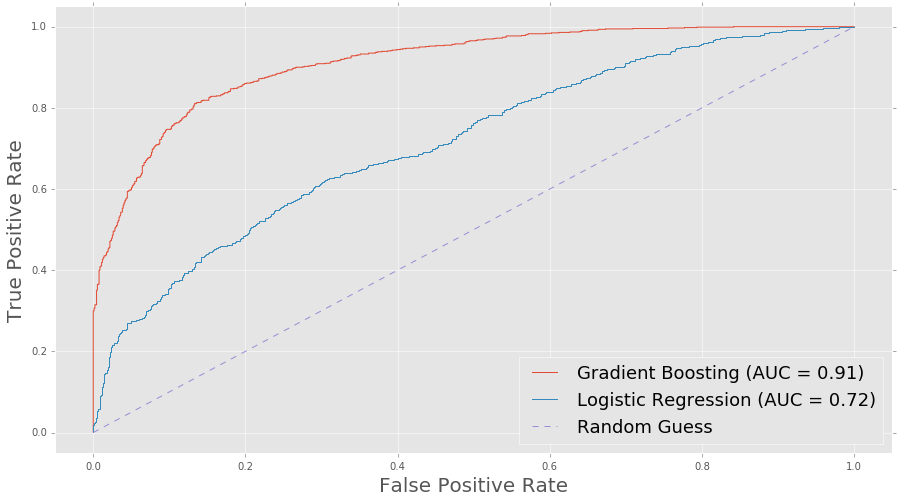

In [109]:
predictions = {'Logistic Regression': state_predicted_probs,
              'Gradient Boosting': state_predicted_probs_xgb}

plt.figure(figsize=(15,8))
for model, preds in predictions.items():
    fpr, tpr, thresholds = roc_curve(state_test, preds[:, 1]) 
    roc_auc = auc(fpr, tpr)
        
    plt.plot(fpr, tpr, lw=1, label = model + ' (AUC = %.2f)' %(roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
    
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
    
#plt.title('ROC Curve')
plt.legend(frameon=True, loc='lower right', fontsize=18)
plt.show()

plt.savefig('roc.png')

This ROC curve looks more realistic

# Conclusion

Gradient Boosting Machine achieves the highest AUC score and accuracy. Both logistic regression and the gradient boosting classifier significantly outperform a dummy classifier, which in our case would be a random guess, since the data is relatively balanced.<br><br>
Our analysis suggests that the data contains rich information from which we can make informed predictions about customer churn.

# Possible further extensions

1. Analysing the URLs to extract some additional features. For example, the quality of a profile picture might correlate with the success of a project
2. Analysing the string features to get more information. For example, buzzwords in a project name / description probably correlate with its success
3. Extracting more features from the existing ones. For instance, it can be that 'rounded' figures are more or less attractive to investors; people might be willing to invest more during the holidays
4. Further parameter tuning, esp. if more computation resources are available

# Resources used
 - https://www.coursera.org/specializations/machine-learning-data-analysis
 - https://dkn22.github.io/ds/churn.html

In [717]:
663816109

663816109